In [2]:
import pandas as pd

# Load your downloaded files with correct filenames
expr = pd.read_csv('HiSeqV2_exon', sep='\t', index_col=0).T
meth = pd.read_csv('HumanMethylation450', sep='\t', index_col=0).T

# Continue with matching samples and preprocessing
common_samples = expr.index.intersection(meth.index)
expr = expr.loc[common_samples]
meth = meth.loc[common_samples]

print(f"Gene Expression shape: {expr.shape}")
print(f"Methylation shape: {meth.shape}")


Gene Expression shape: (873, 239322)
Methylation shape: (873, 485577)


In [3]:
expr_var = expr.var().sort_values(ascending=False).head(1000).index
meth_var = meth.var().sort_values(ascending=False).head(1000).index

expr = expr[expr_var]
meth = meth[meth_var]

# Standardize data (mean=0, variance=1)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
expr_scaled = pd.DataFrame(scaler.fit_transform(expr), index=expr.index, columns=expr.columns)
meth_scaled = pd.DataFrame(scaler.fit_transform(meth), index=meth.index, columns=meth.columns)

In [8]:
from mofapy2.run.entry_point import entry_point
import pandas as pd

# First, transpose to have samples as rows:
expr_df = expr_scaled.copy()  # samples x genes
expr_df['sample'] = expr_df.index
expr_melted = expr_df.melt(id_vars=['sample'], var_name='feature', value_name='value')
expr_melted['view'] = 'expression'

meth_df = meth_scaled.copy()  # samples x methylation sites
meth_df['sample'] = meth_df.index
meth_melted = meth_df.melt(id_vars=['sample'], var_name='feature', value_name='value')
meth_melted['view'] = 'methylation'

# Concatenate both dataframes into one:
data_long = pd.concat([expr_melted, meth_melted], ignore_index=True)
data_long['group'] = 'BRCA'  # Only one group in this example

# Check format
print(data_long.head())

# Set up MOFA
mofa = entry_point()
mofa.set_data_options(scale_views=False)

# Set data with the expected format
mofa.set_data_df(data_long)

# Set model options
mofa.set_model_options(factors=10)

# Set training options
mofa.set_train_options(iter=1000, convergence_mode='medium')

# Build and run
mofa.build()
mofa.run()

# Save results
mofa.save("mofa_BRCA.hdf5")



            sample                    feature     value        view group
0  TCGA-A2-A3XU-01  chr11:62038353-62038540:+  0.063956  expression  BRCA
1  TCGA-AR-A2LR-01  chr11:62038353-62038540:+ -1.521607  expression  BRCA
2  TCGA-B6-A3ZX-01  chr11:62038353-62038540:+  0.400535  expression  BRCA
3  TCGA-OL-A5D7-01  chr11:62038353-62038540:+ -1.304045  expression  BRCA
4  TCGA-E2-A570-01  chr11:62038353-62038540:+  0.691057  expression  BRCA

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ###############

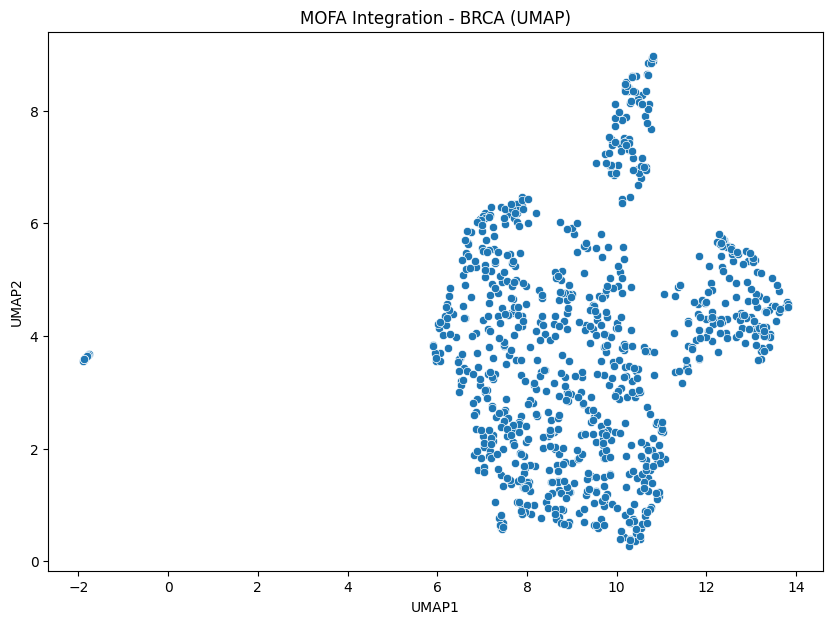

In [12]:
# Correct extraction of latent factors
Z = mofa.model.nodes['Z'].getExpectation()
factors = pd.DataFrame(Z, index=expr_scaled.index)

# Visualization using UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import umap

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(factors)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1])
plt.title("MOFA Integration - BRCA (UMAP)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()



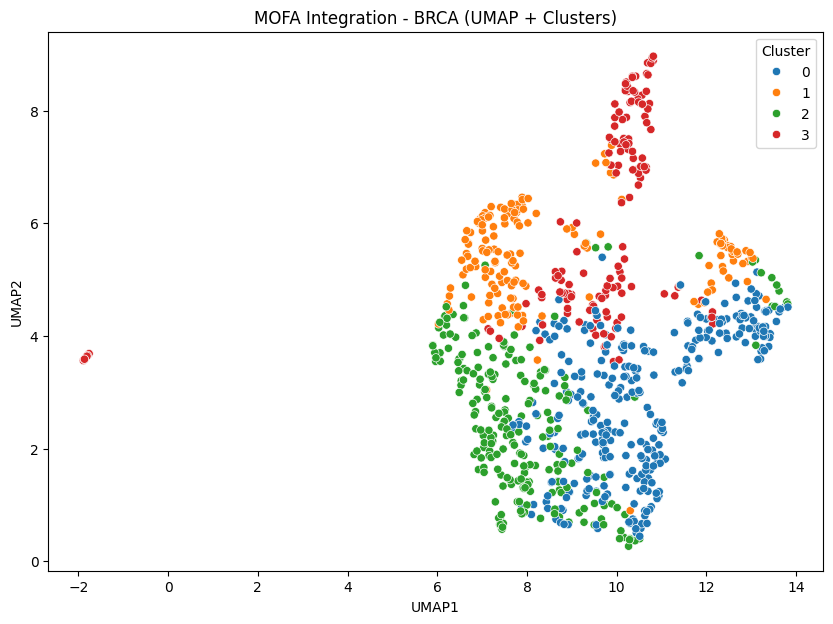

In [13]:
from sklearn.cluster import KMeans

# Perform clustering on latent factors
n_clusters = 4  # or choose the number you prefer
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(factors)

# Now visualize clearly with colors by clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=clusters, palette='tab10')
plt.title("MOFA Integration - BRCA (UMAP + Clusters)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title='Cluster')
plt.show()


Missing values before imputation:
2017
Missing values after imputation:
0


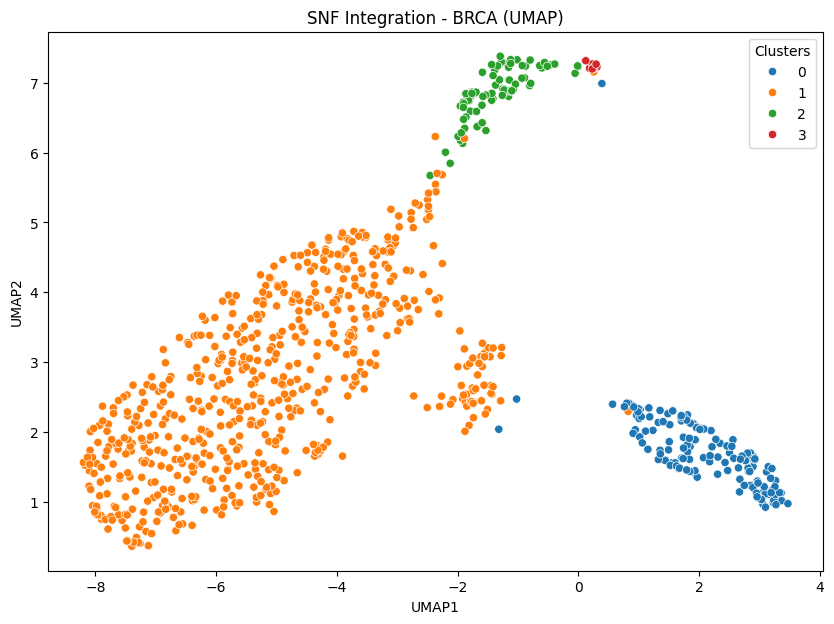

In [10]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import euclidean_distances
import snf
import umap
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns

# Check missing data first:
print("Missing values before imputation:")
print(meth_scaled.isna().sum().sum())

# Impute missing values with median (or mean, depending on preference)
imputer = SimpleImputer(strategy='median')
meth_imputed = pd.DataFrame(
    imputer.fit_transform(meth_scaled),
    index=meth_scaled.index,
    columns=meth_scaled.columns
)

# Verify no more missing values
print("Missing values after imputation:")
print(meth_imputed.isna().sum().sum())

# Continue with SNF (corrected code):
dist_expr = euclidean_distances(expr_scaled)
dist_meth = euclidean_distances(meth_imputed)

# Create similarity matrices
affinity_expr = snf.make_affinity(dist_expr, K=20, mu=0.5)
affinity_meth = snf.make_affinity(dist_meth, K=20, mu=0.5)

# SNF integration
fused_affinity = snf.snf([affinity_expr, affinity_meth], K=20)

# Clustering
clusters = SpectralClustering(n_clusters=4, affinity='precomputed', random_state=42).fit_predict(fused_affinity)

# UMAP visualization
reducer = umap.UMAP(metric='precomputed', random_state=42)
embedding_snf = reducer.fit_transform(1 - fused_affinity)

plt.figure(figsize=(10,7))
sns.scatterplot(x=embedding_snf[:,0], y=embedding_snf[:,1], hue=clusters, palette='tab10')
plt.title("SNF Integration - BRCA (UMAP)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title='Clusters')
plt.show()